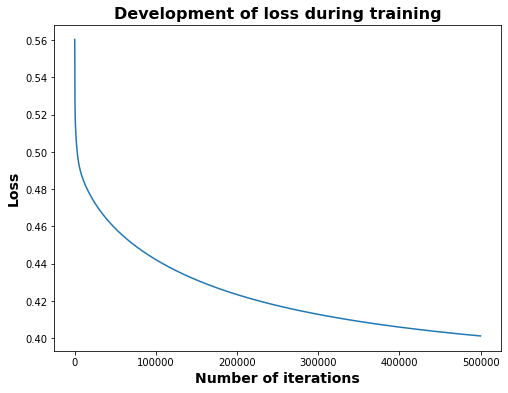

The result of SoftMax prediction is: 
              precision    recall  f1-score   support

     class 1       0.73      0.96      0.83       100
     class 2       0.79      0.29      0.43        51

    accuracy                           0.74       151
   macro avg       0.76      0.63      0.63       151
weighted avg       0.75      0.74      0.69       151

AUC is:  0.7431


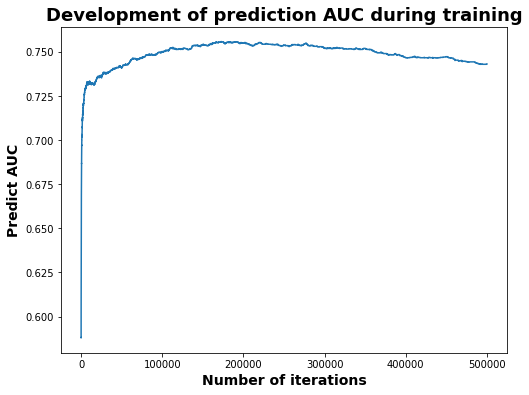

*****END*****
*****Performance of model on training data*****
The result of SoftMax prediction is: 
              precision    recall  f1-score   support

     class 1       0.83      0.95      0.89       729
     class 2       0.70      0.36      0.47       220

    accuracy                           0.82       949
   macro avg       0.77      0.66      0.68       949
weighted avg       0.80      0.82      0.79       949

AUC is:  0.8323
*****END*****


<Figure size 576x432 with 0 Axes>

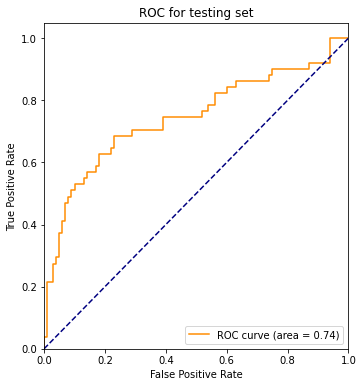

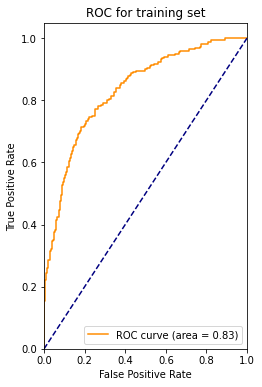

In [4]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import roc_auc_score
class Softmax():
    def __init__(self):
        np.random.seed(119020)
        self.dataLoad()
        self.n_class = np.unique(self.train_y).size  # Find how many classes there are.
        self.n_sample = self.train_x.shape[0]
        self.n_attr = self.train_x.shape[1]
        self.cost_list = []
        self.auc_list = []
        self.train_test = False

    def dataLoad(self):
        origin_train = pd.read_csv("../data/adj_imp_train.csv")
        origin_test = pd.read_csv("../data/adj_imp_test.csv")
        origin_file = pd.concat([origin_train, origin_test], axis=0)
        origin_file["constant"] = 1
        total_x = np.array(origin_file.drop(columns=['class']))
        total_x = preprocessing.normalize(total_x, norm="l2")
        total_y = np.array(origin_file['class'])
        self.train_x = total_x[:origin_train.shape[0]]
        self.test_x = total_x[origin_train.shape[0]:]
        self.train_y = total_y[:origin_train.shape[0]]
        self.test_y = total_y[origin_train.shape[0]:]

    def softMax(self, data, parameter):
        """
        Calculate the classification probability of each class for the given data
        Return the probability martix, soft_max matrix
        Row sum is 1
        """
        product_value = np.exp(np.dot(data, parameter.T))  # calculate the sum(w_i*x_i) for each data point and each model
        line_sum = product_value.sum(axis=1).reshape((product_value.shape[0], -1))  # Sum each row
        soft_max = product_value / line_sum  # Calculate probability
        return soft_max

    def classOneHot(self, label_arr):
        """
        Transform label array into matrix. The size is n*k, k is the number of classes
        This is one-hot transformation
        """
        n_class = np.unique(label_arr).size
        y_matrix = np.zeros((label_arr.shape[0],n_class))
        y_matrix[label_arr==0,0] = 1
        y_matrix[label_arr==1,1] = 1
        return y_matrix

    def softMaxTrain(self, alpha=5, iteration=1000):
        self.parameters = np.random.rand(self.n_class, self.n_attr)  # shape: (2, 64). Initail all the parameters. Each row represents the vector of parameters. 2 rows because there are two models for different type y
        y_one_hot = self.classOneHot(self.train_y)
        w_gradient = 0
        for i in range(iteration):
            self.parameters -= alpha * w_gradient
            self.predict()
            soft_max = self.softMax(self.train_x, self.parameters)
            cost = -1/self.n_sample *(y_one_hot * np.log(soft_max)).sum()  # Calculate cost function
            w_gradient = -1/self.n_sample * np.dot((y_one_hot - soft_max).T, self.train_x)  # Calculate the gradient
            if np.abs(w_gradient.min()) < 2*10e-5:
                break
            self.w = w_gradient
            self.cost_list.append(cost)
        # self.parameters = init_parameter

    def lossVisual(self):
        plt.figure(figsize = (8,6))
        plt.plot(np.arange(len(self.cost_list)), self.cost_list)
        plt.title("Development of loss during training", \
            fontdict={"family": "normal", "weight": "bold", "size": 16})
        plt.xlabel("Number of iterations", fontdict={"family": "normal", "weight": "bold", "size": 14})
        plt.ylabel("Loss", fontdict={"family": "normal", "weight": "bold", "size": 14})
        plt.show()

    def predict(self, train_test=False):
        self.train_test = train_test
        if train_test:
            self.test_x = self.train_x
            self.test_y = self.train_y
        calculate_result = pd.DataFrame(self.softMax(self.test_x, self.parameters))
        calculate_result["predict"] = 0
        calculate_result.loc[calculate_result[1] > calculate_result[0], "predict"] = 1
        self.predict_result = calculate_result["predict"]
        self.classification_prob = calculate_result[1]
        predict_auc = roc_auc_score(np.array(self.test_y), calculate_result[1])
        self.cal_result = calculate_result
        self.auc_list.append(predict_auc)
        # print(calculate_result)

    def resultAnalysis(self):
        plt.figure(figsize = (8,6))
        target_names = ['class 1', 'class 2']
        if self.train_test:
            print("*****Performance of model on training data*****")
        print("The result of SoftMax prediction is: ")
        result = classification_report(self.test_y, self.predict_result, target_names=target_names)
        print(result)
        print("AUC is: ", np.round(self.auc_list[-1], 4))
        if not self.train_test:
            plt.plot(self.auc_list)
            plt.xlabel("Number of iterations", fontdict={"family": "normal", "weight": "bold", "size": 14})
            plt.ylabel("Predict AUC", fontdict={"family": "normal", "weight": "bold", "size": 14})
            plt.title("Development of prediction AUC during training", fontdict={"family": "normal", "weight": "bold", "size": 18})
            plt.show()
        print("*****END*****")

    def draw_roc(self):
        plt.figure(figsize = (8,6))
        score = self.classification_prob
        auc = roc_auc_score(self.test_y, score)
        fpr, tpr, _ = roc_curve(self.test_y, score)
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.plot(fpr, tpr, color='darkorange',
                label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for testing set')
        plt.legend(loc="lower right")

        self.predict(True)
        self.resultAnalysis()
        score = self.classification_prob
        auc = roc_auc_score(self.train_y, score)
        fpr, tpr, _ = roc_curve(self.train_y, score)
        plt.subplot(122)
        plt.plot(fpr, tpr, color='darkorange',
                label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for training set')
        plt.legend(loc="lower right")
        plt.show()

if __name__=="__main__":
    p = Softmax()
    p.softMaxTrain(0.01, 500000)
    p.lossVisual()
    # p.predict()
    p.resultAnalysis()
    p.draw_roc()